In [1]:

!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import math

from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-hfcdbzpb
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-hfcdbzpb
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28111 sha256=a61d602f38f251eb587c8d47113062beac8d55f51eaff0e593e1ecef1710717c
  Stored in directory: /tmp/pip-ephem-wheel-cache-y4_2_cwl/wheels/a8/c4/1a/cee09dcc12a11620066d35ace42e3c1e3bfbcc1db3a0ce7788
Successfully built pyeeg


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
#from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
#from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten
from keras.layers import Dense
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Model
import timeit
from keras.models import Sequential
#from keras.layers.core import Flatten, Dense, Dropout
from keras.layers import Flatten, Dense, Dropout

#from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D


from tensorflow.keras.optimizers import SGD
#import cv2, numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03']
#List of subjects

In [5]:
def FFT_Processing(sub, channel, band, window_size, step_size, sample_rate):
    meta = []
    with open("/content/drive/MyDrive/DL_SIP_PROJECT/data_preprocessed_python/s" + sub + '.dat', 'rb') as file:
        subject = pickle.load(file, encoding='latin1')

        for i in range(40):
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0
            while start + window_size < data.shape[1]:
                meta_array = []
                max_length = 0  # Track the maximum length of meta_data
                for j in channel:
                    X = data[j][start: start + window_size]
                    Y = pe.bin_power(X, band, sample_rate)
                    meta_data = list(Y[0])
                    # Update max_length if necessary
                    max_length = max(max_length, len(meta_data))
                    meta_array.append(meta_data)
                # Pad or truncate all meta_data lists to have the same length
                for k in range(len(meta_array)):
                    meta_array[k] = meta_array[k] + [0] * (max_length - len(meta_array[k]))
                # Flatten the meta_array and append the labels
                flattened_meta_array = [item for sublist in meta_array for item in sublist]
                flattened_meta_array.extend(labels)
                meta.append(flattened_meta_array)
                start += step_size

    meta = np.array(meta)
    np.save('/content/drive/MyDrive/DL_SIP_PROJECT/data_preprocessed_python/s' + sub, meta, allow_pickle=True, fix_imports=True)



In [6]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [7]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:
    with open('/content/drive/MyDrive/DL_SIP_PROJECT/data_preprocessed_python/s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file, allow_pickle=True)
        for i in range(sub.shape[0]):
            if i % 4 == 0:
                data_testing.append(sub[i][:-4])  # Append features excluding the last 4 elements (labels)
                label_testing.append(sub[i][-4:]) # Append the last 4 elements (labels)
            else:
                data_training.append(sub[i][:-4]) # Append features excluding the last 4 elements (labels)
                label_training.append(sub[i][-4:])# Append the last 4 elements (labels)

data_training = np.array(data_training)
label_training = np.array(label_training)
data_testing = np.array(data_testing)
label_testing = np.array(label_testing)

np.save('/content/drive/MyDrive/DL_SIP_PROJECT/70_30_2/data_training', data_training, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DL_SIP_PROJECT/70_30_2/label_training', label_training, allow_pickle=True, fix_imports=True)
print("training dataset:", data_training.shape, label_training.shape)

np.save('/content/drive/MyDrive/DL_SIP_PROJECT/70_30_2/data_testing', data_testing, allow_pickle=True, fix_imports=True)
np.save('/content/drive/MyDrive/DL_SIP_PROJECT/70_30_2/label_testing', label_testing, allow_pickle=True, fix_imports=True)
print("testing dataset:", data_testing.shape, label_testing.shape)

training dataset: (43920, 70) (43920, 4)
testing dataset: (14640, 70) (14640, 4)


In [8]:
with open('/content/drive/MyDrive/DL_SIP_PROJECT/70_30/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)

with open('/content/drive/MyDrive/DL_SIP_PROJECT/70_30/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)

X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [9]:
X.shape

(43920, 70)

In [10]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(Z)
y_train


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:

y_train.shape

(43920, 10)

In [12]:

x_train = np.array(X[:])

In [13]:
with open('/content/drive/MyDrive/DL_SIP_PROJECT/70_30_2/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)

with open('/content/drive/MyDrive/DL_SIP_PROJECT/70_30_2/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [14]:

x_test = np.array(M[:])

In [15]:
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(L)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:

y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [17]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)


In [18]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [19]:

x_train.shape

(43920, 70, 1)

In [20]:

batch_size = 64
num_classes = 10
epochs = 200
input_shape=(x_train.shape[1], 1)

In [21]:

print(input_shape)

(70, 1)


In [22]:

from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

In [23]:
model = Sequential()
intput_shape=(x_train.shape[1], 1)
model.add(Conv1D(164, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(164,kernel_size=3,padding = 'same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Conv1D(82,kernel_size=3,padding = 'same', activation='relu'))
model.add(MaxPooling1D(pool_size=(2)))
model.add(Flatten())
model.add(Dense(82, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(42, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(21, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 70, 164)           656       
                                                                 
 batch_normalization (Batch  (None, 70, 164)           656       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 35, 164)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 164)           80852     
                                                                 
 batch_normalization_1 (Bat  (None, 35, 164)           656       
 chNormalization)                                                
                                                        

In [24]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,validation_data=(x_test,y_test))

Epoch 1/200
687/687 [==============================] - 16s 9ms/step - loss: 1.6298 - accuracy: 0.3192 - val_loss: 1.4351 - val_accuracy: 0.4098
Epoch 2/200
687/687 [==============================] - 7s 10ms/step - loss: 1.4578 - accuracy: 0.3964 - val_loss: 1.3122 - val_accuracy: 0.4599
Epoch 3/200
687/687 [==============================] - 5s 8ms/step - loss: 1.3447 - accuracy: 0.4528 - val_loss: 1.2061 - val_accuracy: 0.5040
Epoch 4/200
687/687 [==============================] - 6s 9ms/step - loss: 1.2337 - accuracy: 0.5009 - val_loss: 1.0919 - val_accuracy: 0.5559
Epoch 5/200
687/687 [==============================] - 6s 9ms/step - loss: 1.1425 - accuracy: 0.5380 - val_loss: 1.0329 - val_accuracy: 0.5783
Epoch 6/200
687/687 [==============================] - 6s 9ms/step - loss: 1.0753 - accuracy: 0.5666 - val_loss: 0.9698 - val_accuracy: 0.6042
Epoch 7/200
687/687 [==============================] - 7s 10ms/step - loss: 1.0154 - accuracy: 0.5922 - val_loss: 0.8889 - val_accuracy: 0.6

In [26]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

458/458 [==============================] - 2s 4ms/step - loss: 0.4466 - accuracy: 0.8641
Test loss: 0.4465724527835846
Test accuracy: 0.8641393184661865


In [27]:
# list all data in history
print(history.history.keys())
import matplotlib.pyplot as plt
import numpy

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


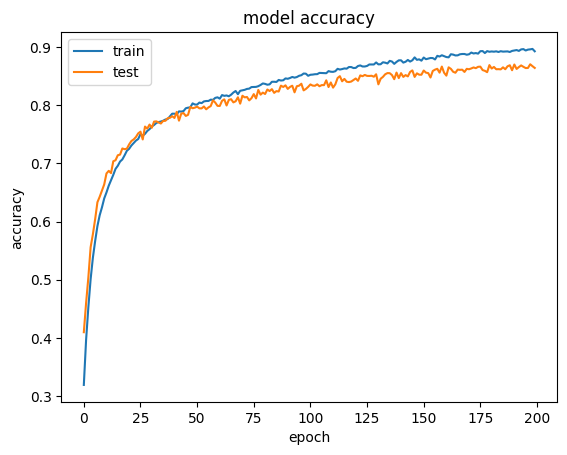

In [28]:

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

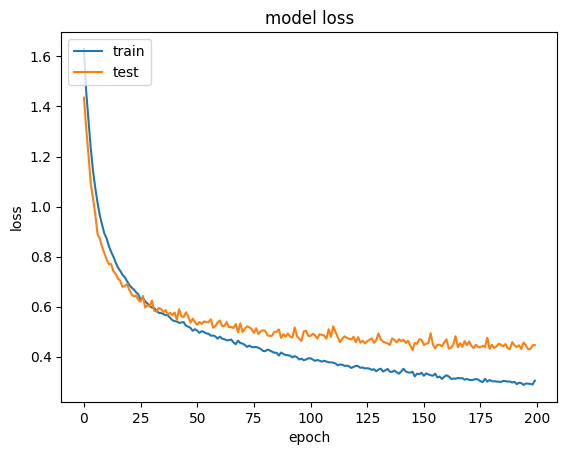

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

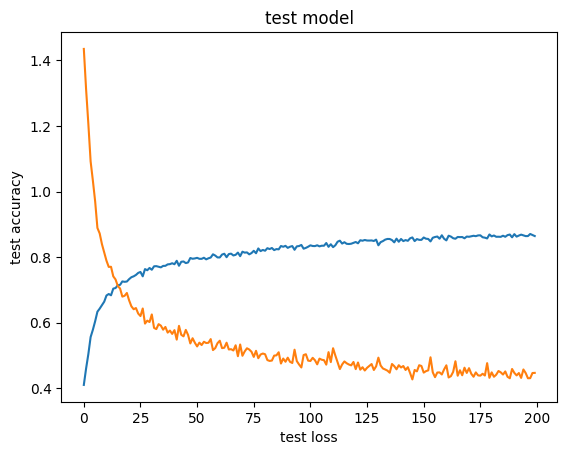

In [30]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

In [31]:
y_pred=model.predict(x_test)
from sklearn.metrics import confusion_matrix
import numpy as np

458/458 [==============================] - 2s 4ms/step


In [32]:
y_test[1]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [33]:
y_pred[1]

array([0.0000000e+00, 7.0174884e-09, 0.0000000e+00, 4.1757372e-07,
       6.8971120e-11, 1.8280569e-05, 5.5743785e-05, 9.9992549e-01,
       2.1531935e-08, 9.2289010e-14], dtype=float32)

In [34]:
y_test1=np.argmax(y_test, axis=1)

In [35]:

y_pred=np.argmax(y_pred,axis=1)

In [36]:
y_test1[1]

7

In [37]:

y_pred[1]

7

In [38]:

cmatrix=confusion_matrix(y_test1, y_pred)

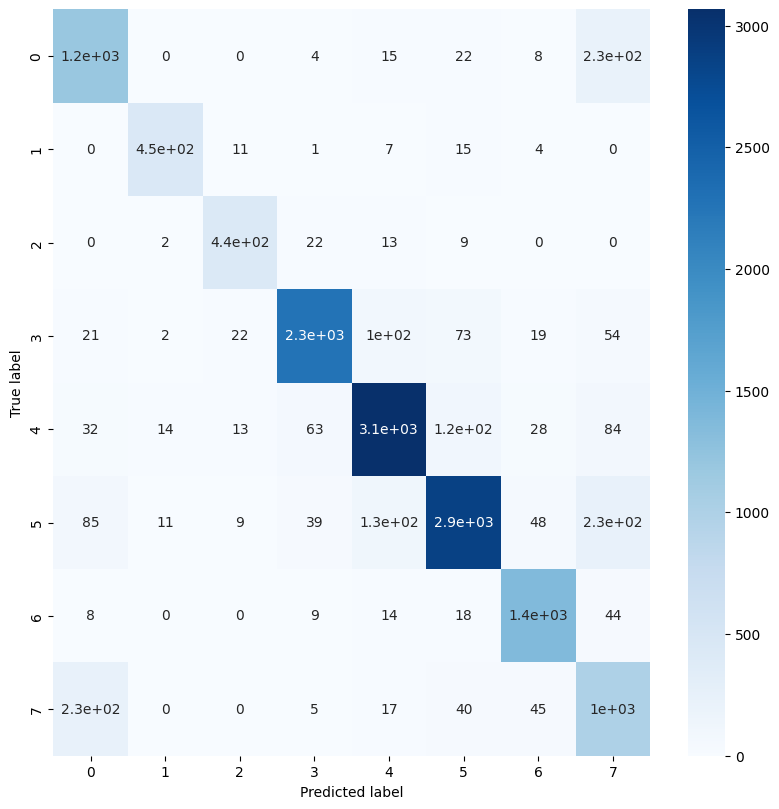

In [39]:

import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [40]:

from sklearn import metrics
y_pred = np.around(model.predict(x_test))
print(metrics.classification_report(y_test,y_pred))

458/458 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.80      0.75      0.78      1464
           2       0.00      0.00      0.00         0
           3       0.95      0.92      0.93       488
           4       0.89      0.90      0.90       488
           5       0.95      0.87      0.91      2562
           6       0.93      0.89      0.91      3416
           7       0.92      0.82      0.87      3416
           8       0.91      0.93      0.92      1464
           9       0.79      0.57      0.66      1342

   micro avg       0.91      0.83      0.87     14640
   macro avg       0.71      0.67      0.69     14640
weighted avg       0.90      0.83      0.86     14640
 samples avg       0.83      0.83      0.83     14640

